# Mini Lab

## Brett Hallum, Mridul Jain, and Solomon Ndungu

The purpose of this project is to use logistic regression and SVM to create a classification model for a loan data. We will use the model to classify loans as good if the loan end up as current, fully paid or in grace period and bad if those laons eventually end up in default, late or charged off.

We started by filtering out our unwanted data. A lot of this information was removed in Lab 1 due to missing values, single values for whole set, and a minimal distribution of values. Additionally, we do some imputation to fill in minor missing data values. Finally, we do some nominal classification on some of our data variables for ease of use in classification.

We also create two additional data frames, loan_df_finished and loan_df_unfinished, at this point as well. Their purpose and usage will be discussed shortly.


# Resubmission portion:

We have created Subsampled dataset from the complete data (from Line [7]) using the code mentioned below:

### Randomly sample X% of your dataframe for future use (We will use small subset of data for SVM (Batch) classification)

'subsampled_df = loan_df_finished.copy().sample(frac=0.05)'

For the analysis part, a new section is inserted at the bottom of the document after "Analysis 2: Reduced Number of Factors". The section is titled with the question we are reanswering "Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain"

In [1]:
# import os
# os.chdir('C:/Users/emrijai/Documents/IPython Notebooks/MS7331/Project1/MSDS7331_Project1')
# os.getcwd()

In [2]:
import pandas as pd
import numpy as np
import copy

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter("ignore")

#Bring in data set
loan_df = pd.read_csv('LoanData/loanData.csv')

#Remove unwanted attributes from the data set based on specific criteria
for col in ['id','funded_amnt_inv','sub_grade','emp_title','pymnt_plan','url','title','zip_code','earliest_cr_line',
            'mths_since_last_delinq','mths_since_last_record','pub_rec','revol_bal','revol_util',
            'initial_list_status','out_prncp_inv','total_pymnt_inv','recoveries','collection_recovery_fee','last_pymnt_d',
            'last_pymnt_amnt','next_pymnt_d','last_credit_pull_d','collections_12_mths_ex_med','policy_code','application_type',
            'annual_inc_joint','dti_joint','verification_status_joint','open_acc_6m','open_il_6m','open_il_12m','open_il_24m',
            'mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util',
            'total_rev_hi_lim','inq_fi','total_cu_tl','inq_last_12m', 'installment', 'mths_since_last_major_derog', 'desc',
           'issue_d', 'addr_state', 'tot_coll_amt', 'tot_cur_bal', 'member_id', 'total_rec_prncp', 'total_rec_int',
           'total_rec_late_fee', 'loan_amnt', 'out_prncp']:
    if col in loan_df:
        del loan_df[col]

#Create new variables for classification
#Modify term to be integer for easier analysis
loan_df = loan_df.replace(to_replace=" 36 months", value=36)
loan_df = loan_df.replace(to_replace=" 60 months", value=60)

#Impute missing data values with median
for col in ['annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'acc_now_delinq']:
    df_temp = copy.deepcopy(loan_df[col])
    df_temp = df_temp.replace(to_replace=np.nan, value=df_temp.median())
    loan_df[col] = df_temp
    
#Numerical classification of grade
tmp_df = pd.get_dummies(loan_df.grade,prefix='Grade')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "grade" in loan_df:
    del loan_df["grade"]
    
#Numerical classification of employment length
tmp_df = pd.get_dummies(loan_df.emp_length,prefix='Employ')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "emp_length" in loan_df:
    del loan_df["emp_length"]

#Range of interest rates
loan_df['Int_Rate_Range'] = pd.cut(loan_df.int_rate, [0, 5,10,15,20,25, 30], 6, labels=[0, 1, 2, 3, 4, 5])

if "int_rate" in loan_df:
    del loan_df["int_rate"]

#Nominal classification of loan_status
loan_df.loc[loan_df['loan_status'] == 'Charged Off' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Default' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Late (31-120 days)' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Late (16-30 days)' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off' , 'Loan_Class'] = 0

loan_df.loc[loan_df['loan_status'] == 'Fully Paid' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid' , 'Loan_Class'] = 1

loan_df.loc[loan_df['loan_status'] == 'Current' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'In Grace Period' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'Issued' , 'Loan_Class'] = 1

#Secondary classification of loan class for further analysis of data (used for new data frames)
# comparing the historical data (good/bad loans) to current data (loans still in progress)
# Loans are classified as 'Bad' if loans are bad
loan_df.loc[loan_df['loan_status'] == 'Charged Off' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Default' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Late (31-120 days)' , 'Loan_Class2'] = 'bad'
loan_df.loc[loan_df['loan_status'] == 'Late (16-30 days)' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off' , 'Loan_Class2'] = 'Bad'
# Loans are classified as 'Good' if loans are good
loan_df.loc[loan_df['loan_status'] == 'Fully Paid' , 'Loan_Class2'] = 'Good'
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid' , 'Loan_Class2'] = 'Good'
# Loans are classified as 'Current' if loans are current/still in progress
loan_df.loc[loan_df['loan_status'] == 'Current' , 'Loan_Class2'] = 'Current'
loan_df.loc[loan_df['loan_status'] == 'In Grace Period' , 'Loan_Class2'] = 'Current'
loan_df.loc[loan_df['loan_status'] == 'Issued' , 'Loan_Class2'] = 'Current'

if "loan_status" in loan_df:
    del loan_df["loan_status"]

#Nominal classification of verification status
loan_df.loc[loan_df['verification_status'] == 'Verified', 'Verify_Status'] = 1
loan_df.loc[loan_df['verification_status'] == 'Source Verified', 'Verify_Status'] = 1
loan_df.loc[loan_df['verification_status'] == 'Not Verified', 'Verify_Status'] = 0

if "verification_status" in loan_df:
    del loan_df["verification_status"]

#Nominal classification of home ownership
tmp_df = pd.get_dummies(loan_df.home_ownership,prefix='Home')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "home_ownership" in loan_df:
    del loan_df["home_ownership"]

#Impute missing data values with median
for col in ['total_acc']:
    df_temp = copy.deepcopy(loan_df[col])
    df_temp = df_temp.replace(to_replace=np.nan, value= 0 )
    loan_df[col] = df_temp    

    
tmp_df = pd.get_dummies(loan_df.purpose,prefix='Loan_Purpose')
loan_df = pd.concat((loan_df,tmp_df),axis=1)

if 'purpose' in loan_df:
    del loan_df['purpose']    
    
# Create separate data frames for future analysis and breakdown
loan_df_unfinished = loan_df[loan_df['Loan_Class2'] == 'Current'] #Data of uncompleted loans
loan_df_finished = loan_df[(loan_df['Loan_Class2'] == 'Bad') | (loan_df['Loan_Class2']=='Good')] #Data of completed loans


loan_df.copy()

if "Loan_Class2" in loan_df:
    del loan_df["Loan_Class2"]

print loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 52 columns):
funded_amnt                        887379 non-null int64
term                               887379 non-null int64
annual_inc                         887379 non-null float64
dti                                887379 non-null float64
delinq_2yrs                        887379 non-null float64
inq_last_6mths                     887379 non-null float64
open_acc                           887379 non-null float64
total_acc                          887379 non-null float64
total_pymnt                        887379 non-null float64
acc_now_delinq                     887379 non-null float64
Grade_A                            887379 non-null float64
Grade_B                            887379 non-null float64
Grade_C                            887379 non-null float64
Grade_D                            887379 non-null float64
Grade_E                            887379 non-null float64
Grade_F 

In [3]:
loan_df = loan_df.dropna()
print loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 887379 entries, 0 to 887378
Data columns (total 52 columns):
funded_amnt                        887379 non-null int64
term                               887379 non-null int64
annual_inc                         887379 non-null float64
dti                                887379 non-null float64
delinq_2yrs                        887379 non-null float64
inq_last_6mths                     887379 non-null float64
open_acc                           887379 non-null float64
total_acc                          887379 non-null float64
total_pymnt                        887379 non-null float64
acc_now_delinq                     887379 non-null float64
Grade_A                            887379 non-null float64
Grade_B                            887379 non-null float64
Grade_C                            887379 non-null float64
Grade_D                            887379 non-null float64
Grade_E                            887379 non-null float64
Grade_F 

In [4]:
#Count for each class
df_grouped = loan_df.groupby(by='Loan_Class')
print df_grouped.Loan_Class.count()

Loan_Class
0.0     61176
1.0    826203
Name: Loan_Class, dtype: int64


In [5]:
from sklearn.cross_validation import ShuffleSplit

# Split our data frame into our classification of Loan_Class and the rest of the data set
if 'Loan_Class' in loan_df:
    y = loan_df['Loan_Class'].values
    del loan_df['Loan_Class']
    X = loan_df.values

# Shuffle split our data into an 80/20 breakdown. The 80 will be used for training and the 20 for testing
num_cv_iterations = 5
num_instances = len(y)
cv_obj = ShuffleSplit(n = num_instances, n_iter = num_cv_iterations, test_size = 0.2)

print cv_obj

ShuffleSplit(887379, n_iter=5, test_size=0.2, random_state=None)


### Logistic Regression

We will begin by conducting a logistic regression on the full data set. We will look at the accuracy of the classification to see how accurate the regression model is and the confusion matrix to see if there are any oddities in the breakdown.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

logreg_obj = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

# Fit and test the regression model for each shuffled instance
for iter_num, (train_indices, test_indices) in enumerate(cv_obj):
    logreg_obj.fit(X[train_indices],y[train_indices])  # train object
    y_hat = logreg_obj.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print "====Iteration",iter_num," ===="
    print "accuracy", mt.accuracy_score(y[test_indices],y_hat) 
    print "confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat)

====Iteration 0  ====
accuracy 0.931517500958
confusion matrix
[[     0  12154]
 [     0 165322]]
====Iteration 1  ====
accuracy 0.931111812301
confusion matrix
[[     0  12226]
 [     0 165250]]
====Iteration 2  ====
accuracy 0.931590750299
confusion matrix
[[     0  12141]
 [     0 165335]]
====Iteration 3  ====
accuracy 0.930790642115
confusion matrix
[[     0  12283]
 [     0 165193]]
====Iteration 4  ====
accuracy 0.930914602538
confusion matrix
[[     0  12261]
 [     0 165215]]


The average accuracy is around 93.1%. It seems logistic regression method is effective in  classifying the loans. However, if we look at the confusion matrix, all of the "Bad" classifications of the loans are getting classified as "Good". This most likely  because our data is heavily skewed. Of the total data set, only about 7% of the loans are classified as bad. The data set is further skewed due to loans that are in different payment lifecyle. We have data that has been through the full process of the loan and has been determined to be either good, meaning the loan is complete, or bad, meaning the loan went into default and the company has written it off. The rest of our data, which is a good portion of it, are loans that are still current, or in the process of going through the full life cycle. Some of these loans could still go into default, but we do not know if they will or not.

To handle this in our classification, we split our data up. We created a data frame of finished loans (loan_df_finished) to clarify those that have been completed and a data frame of current loans (loan_df_unfinished) to specify those that have not finished their life cycle. We will use the finished loans data frame to try to classify our data better. The unfinished data frame can then be used later for cross validation.

In [7]:
# Add column to determine if loan is good or bad based on classification in data set
loan_df_finished['isGoodLoan'] = loan_df_finished['Loan_Class2'] == 'Good'
loan_df_finished.isGoodLoan = loan_df_finished.isGoodLoan.astype(np.int)


import pandas
# Randomly sample X% of your dataframe for future use (We will use small subset of data for SVM (Batch) classification)
subsampled_df = loan_df_finished.copy().sample(frac=0.05)

#Remove Loan_Class and Loan_Class2 from the data frame so they are no longer observed for classification
if "Loan_Class" in loan_df_finished:
    del loan_df_finished["Loan_Class"]
if "Loan_Class2" in loan_df_finished:
    del loan_df_finished["Loan_Class2"]
    
#Remove Loan_Class and Loan_Class2 from the data frame so they are no longer observed for classification
if "Loan_Class" in subsampled_df:
    del subsampled_df["Loan_Class"]
if "Loan_Class2" in subsampled_df:
    del subsampled_df["Loan_Class2"]

In [8]:
# Split the data into our x and y matrices for testing
if 'isGoodLoan' in loan_df_finished:
    updated_y = loan_df_finished['isGoodLoan'].values
    del loan_df_finished['isGoodLoan']
    updated_X = loan_df_finished.values

# Create a new Shuffle split on the narrowed classification data
num_cv_iterations = 5
num_instances = len(updated_y)
updated_cv_obj = ShuffleSplit(n = num_instances, n_iter = num_cv_iterations, test_size = 0.2)
print updated_cv_obj

ShuffleSplit(259296, n_iter=5, test_size=0.2, random_state=None)


In [9]:
subsampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12965 entries, 22457 to 159835
Data columns (total 52 columns):
funded_amnt                        12965 non-null int64
term                               12965 non-null int64
annual_inc                         12965 non-null float64
dti                                12965 non-null float64
delinq_2yrs                        12965 non-null float64
inq_last_6mths                     12965 non-null float64
open_acc                           12965 non-null float64
total_acc                          12965 non-null float64
total_pymnt                        12965 non-null float64
acc_now_delinq                     12965 non-null float64
Grade_A                            12965 non-null float64
Grade_B                            12965 non-null float64
Grade_C                            12965 non-null float64
Grade_D                            12965 non-null float64
Grade_E                            12965 non-null float64
Grade_F             

In [10]:
updated_logreg_obj = LogisticRegression(penalty='l2', C=10, class_weight=None)

for iter_num, (train_indices, test_indices) in enumerate(updated_cv_obj):
    updated_logreg_obj.fit(updated_X[train_indices],updated_y[train_indices])  # train object
    updated_y_hat = updated_logreg_obj.predict(updated_X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print "==== Iteration",iter_num," ===="
    print "accuracy", mt.accuracy_score(updated_y[test_indices],updated_y_hat) 
    print "confusion matrix\n",mt.confusion_matrix(updated_y[test_indices],updated_y_hat)

==== Iteration 0  ====
accuracy 0.979733898959
confusion matrix
[[ 8975   976]
 [   75 41834]]
==== Iteration 1  ====
accuracy 0.981122252218
confusion matrix
[[ 9055   902]
 [   77 41826]]
==== Iteration 2  ====
accuracy 0.981623602005
confusion matrix
[[ 9091   864]
 [   89 41816]]
==== Iteration 3  ====
accuracy 0.979772464327
confusion matrix
[[ 8968   966]
 [   83 41843]]
==== Iteration 4  ====
accuracy 0.981122252218
confusion matrix
[[ 8989   910]
 [   69 41892]]


The results of this classification not only have a higher accuracy than the original, full data set, an average of 98.0% versus 93.1%, but it also has better looking confusion matrices. There are data points that are classified correctly. Although there are still a larger number of bad loans being incorrectly identified as good, it is much better distributed than the original set.

We follow up this analysis by looking at the weight of each factor used. This will help us figure out if there are certain features that are more influential than others to help with the classification of each point.

In [11]:
from sklearn.preprocessing import StandardScaler

# Non-normalized weights
# Iterate over the coefficients to get the weight for each variable
weights = updated_logreg_obj.coef_.T # take transpose to make a column vector
variable_names = loan_df_finished.columns
for coef, name in zip(weights,variable_names):
    print name, 'has weight of', coef[0]

funded_amnt has weight of -0.00176211214332
term has weight of 0.0165818657439
annual_inc has weight of 1.49363379955e-05
dti has weight of 0.00818293631107
delinq_2yrs has weight of 6.49908995493e-05
inq_last_6mths has weight of 1.57624006492e-05
open_acc has weight of 0.00425491155736
total_acc has weight of 0.0105657537842
total_pymnt has weight of 0.00177192827273
acc_now_delinq has weight of 2.38308573364e-06
Grade_A has weight of 0.000321055655831
Grade_B has weight of 0.000235560099647
Grade_C has weight of 0.000107114094319
Grade_D has weight of -5.93587903007e-05
Grade_E has weight of -4.60314015363e-05
Grade_F has weight of -3.13706000327e-05
Grade_G has weight of -1.17911133936e-05
Employ_1 year has weight of 4.7322864678e-05
Employ_10+ years has weight of 9.12203016614e-05
Employ_2 years has weight of 6.32959947935e-05
Employ_3 years has weight of 5.05494101331e-05
Employ_4 years has weight of 3.36881916044e-05
Employ_5 years has weight of 2.04687776427e-05
Employ_6 years h

We want to normalize the weights for each variable so that a much larger valued variable, such as the funded amount, is weighted the same as a small valued variable such as one that is binary or nominal.

In [12]:
warnings.simplefilter("ignore")

# Normalize the features
scale_obj = StandardScaler()
scale_obj.fit(updated_X[train_indices])

X_train_scaled = scale_obj.transform(updated_X[train_indices]) # apply to training
X_test_scaled = scale_obj.transform(updated_X[test_indices])

# Fit the regression to the new scaled data
updated_logreg_obj.fit(X_train_scaled, updated_y[train_indices])

y_hat = updated_logreg_obj.predict(X_test_scaled)

# Rescore the accuracy and confusion matrix for the scaled data
acc = mt.accuracy_score(updated_y[test_indices],y_hat)
conf = mt.confusion_matrix(updated_y[test_indices],y_hat)
print 'accuracy:', acc 
print conf

# Sort the attributes on size and print them out in order of weight
zip_vars = zip(updated_logreg_obj.coef_.T,loan_df_finished.columns) # combine attributes
zip_vars.sort(key = lambda t: np.abs(t[0])) # sort them by the magnitude of the weight
for coef, name in zip_vars:
    print name, 'has weight of', coef[0] # now print them out

accuracy: 0.980293096799
[[ 8948   951]
 [   71 41890]]
Employ_4 years has weight of 0.000434783716946
Employ_9 years has weight of 0.0023324632599
Employ_1 year has weight of 0.00444800066245
Loan_Purpose_moving has weight of -0.00498120370249
term has weight of 0.0053475190932
Employ_6 years has weight of -0.00558757538437
Grade_F has weight of 0.00610519994757
Loan_Purpose_renewable_energy has weight of -0.00685678238495
Employ_2 years has weight of 0.011231747597
Loan_Purpose_house has weight of 0.0123983353309
Grade_G has weight of 0.013631673077
delinq_2yrs has weight of 0.013854472461
Employ_< 1 year has weight of 0.0142170130313
Loan_Purpose_home_improvement has weight of -0.01525999016
Employ_3 years has weight of 0.0166994025817
Loan_Purpose_car has weight of -0.0172722995085
Home_ANY has weight of 0.0175255792198
Employ_10+ years has weight of 0.0178351816855
Loan_Purpose_vacation has weight of -0.0186172865544
Loan_Purpose_medical has weight of -0.0192549606117
Loan_Purpose

After scaling the data, we still get a similar accuracy to before, if not a little better, and our confusion matrix has remained proportional. The scaled view of the variables provides a better way to compare variables for their significance in the classification.

The graph below provides a better visual of the variables with the most impact. 

- The funded amount and total payment variables have a significant impact over any of the rest of the variables. 
- Interest Rate Range, annual income and the number of total accounts someone also shows more signifiance than the rest of the variables

These results are very reasonable. It makes sense that good loans would have a higher total payment paid off than bad ones, so this would be an important factor in classification. If the loan is in good standing, the full principle amount will be paid off. This will relate positively because as you pay more back to the bank, you will become closer to finishing the loan. Alternatively, the less money you have paid the more likely you are to default on the loan. Funded amount and interest rate range are also valuable. Banks use credit scoring to determine the amount to fund and at what interest rates. Those with bad credit are likely to have lower funded amount and higher interest rate and also a higher chance of the loan ending up as bad. The funded amount and interest rate are both negatively weighted in this case which means the higher the interest rate and the higher the funded amount, the more likely someone is to default. As a loan increases in value and interest rate, it gets more difficult to pay off the loan and so, in general, someone is more likely to go into default and end up with a "bad" loan.

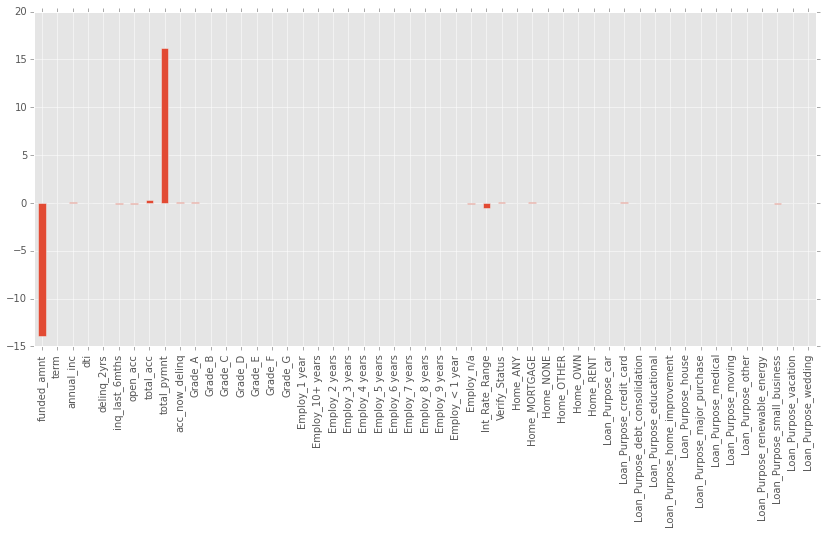

In [13]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
fig = plt.figure(figsize=(14, 6))

weights = pd.Series(updated_logreg_obj.coef_[0],index=loan_df_finished.columns)
weights.plot(kind='bar')
plt.show()

### Support Vector Machines

We continue our trials by observing the Support Vector Machines (SVM) to see if this method of classification can classify our data set better than logistic regression. We will start by observing the SVM of our original data set. Although it will most likely turn out the same way, not giving very good data, the SVM may reveal new splits in the decision. We will follow that up with looking at the SVM of the reduced data set that contains the completed loans. We can compare the accuracy of the SVM with the above logistic regression to determine if one classifies this data better than the other.

Note: We use the SGDClassifier due to the size of our data set. Both sets are large and would take too long to train with a normal SVM in a time that is reasonable.

SVM: 0.931838671144
Confusion Matrix:
[[     0  12097]
 [     0 165379]]
Coefficients [[ -1.50538780e-06   1.11086625e-05   2.95031469e-05  -4.83753326e-06
    5.59442381e-06   1.48632083e-07   8.57014326e-06  -6.23317613e-06
    3.15085392e-05   2.28186123e-05  -2.58348568e-05  -6.45009867e-06
   -3.01126076e-06   1.52205734e-05   2.31640404e-05   2.43310822e-05
   -2.25016957e-05   7.54478692e-06  -1.79843388e-05   2.00554436e-05
   -2.20752055e-05   6.80792833e-06  -1.08692954e-05  -1.06727522e-06
    1.41205648e-06   1.06716673e-05   1.33127332e-06   1.71450697e-05
    2.64490433e-06  -3.39643270e-05   1.27628390e-05   1.70733969e-05
    1.20017024e-05  -2.97359574e-04   1.14117378e-04   1.55958354e-06
   -1.17406137e-05   3.32581065e-05  -4.89708024e-06  -1.50288287e-05
    5.07400526e-05  -9.82013981e-06   1.15062711e-05  -1.63598446e-05
    1.10663335e-05  -5.33391865e-07   9.55028388e-06   9.86596528e-05
    1.31102851e-05  -1.58381634e-06   3.92449695e-05]]


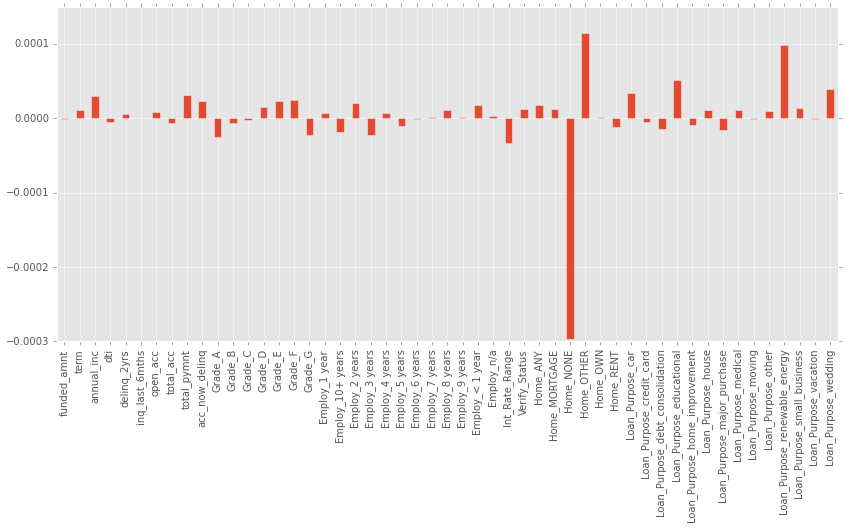

In [14]:
# SVM of full data set
warnings.simplefilter("ignore")

# SGDClassifier using 'hinge' for loss to get an SVM
from sklearn.linear_model import SGDClassifier

# Get SVM classifier
regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l2')

# Fit our data (after it is scaled) to an SVM classification
scl = StandardScaler()
for train_idx, test_idx in cv_obj:
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print 'SVM:', acc
print 'Confusion Matrix:\n', conf
print 'Coefficients', svm_sgd.coef_
weights = pd.Series(svm_sgd.coef_[0],index=loan_df_finished.columns)
weights.plot(kind='bar', figsize=(14,6))

The accuracy of the full data set remained very similar. It stayed at around 93% accuracy, but still has the same style of confusion matrix from the logistic regression with bad loans being classified as good ones. Looking at the breakdown of the weights, there is also no clear classification class. All class values are relatively small, and changing to different breakdowns of the data set lead to different weights having different importances. We now look at the SVM of the reduced data to see how it performs.

SVM: 0.877150019283
Confusion Matrix:
[[ 3448  6346]
 [   25 42041]]
SVM: 0.873968376398
Confusion Matrix:
[[ 3368  6521]
 [   15 41956]]
SVM: 0.876185885075
Confusion Matrix:
[[ 3379  6400]
 [   21 42060]]
SVM: 0.873370613189
Confusion Matrix:
[[ 3390  6542]
 [   25 41903]]
SVM: 0.874990358658
Confusion Matrix:
[[ 3419  6452]
 [   31 41958]]
Coefficients [[ -7.24719832e-01  -3.55572256e-02  -2.17755306e-03  -1.28555777e-02
   -1.51402541e-03  -4.76638582e-03  -6.33280767e-03   1.21968606e-02
    8.45203509e-01   2.02889197e-03  -2.58132441e-03   4.84940882e-03
    6.97499617e-03   3.25002245e-03  -3.82363984e-03  -1.91228157e-02
   -1.24046802e-02  -8.32594537e-04   1.65149542e-03   9.40574567e-04
    3.37661393e-04   2.41010754e-04  -1.51371530e-03  -1.63871508e-03
   -9.82037459e-04   4.44698455e-04  -1.00891003e-03   8.50748134e-04
   -5.77530303e-04  -4.30988594e-02  -7.62223124e-03   4.39792811e-03
    3.46590960e-05   3.90089267e-05   8.17000763e-04   2.37716392e-03
   -1.457484

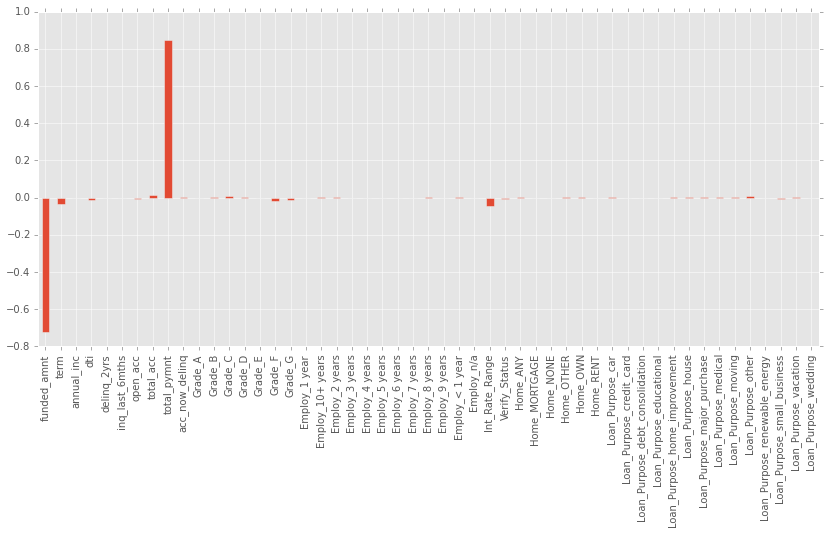

In [15]:
'''

# Running SVM of the loan_df_finished dataset
# We are using Stochastic gradient descent (SGD) because it computes the gradient using a single sample
One benefit of SGD is that it's computationally a whole lot faster. Large datasets often can't be held in RAM, 
which makes vectorization much less efficient. 
Rather, each sample or batch of samples must be loaded, worked with, the results stored, and so on.

#SGDClassifier using 'hinge' for loss to get an SVM

'''

from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in updated_cv_obj:
    svm_sgd.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
    yhat = svm_sgd.predict(scl.transform(updated_X[test_idx]))
    
    conf = mt.confusion_matrix(updated_y[test_idx],yhat)
    acc = mt.accuracy_score(updated_y[test_idx],yhat)

    print 'SVM:', acc
    print 'Confusion Matrix:\n', conf
    
print 'Coefficients', svm_sgd.coef_
weights = pd.Series(svm_sgd.coef_[0],index=loan_df_finished.columns)
weights.plot(kind='bar', figsize=(14,6))

The SVM for the reduced data, which includes just completed loans, has a much lower accuracy than the logistic regression classification of the same data. The accuracy dropped from just below 98.0% to around 87.3%. This is a significant difference. It is possible that part of this is due to SGDClassifier taking the Stochastic Gradient instead of the full gradient of the SVM. Although the SGD runs faster than the linear regression model we used (LinearRegression()), it does not have the accuracy that we would expect or want in this situation, especially when the original data stayed around the same accuracy between the two different classifications.

It is interesting to note that the classes that the SVM pulls out are almost identical to the ones the logistic regression uses. Funded amount and total payment are still at the top of the list with Interest Rate Range being a distant fourth, but still near the top. Surprisingly, it has added importance on the 'Term' variable that the logistic regression did not pull out.

### Additional Analysis: Are there better parameter or variable choices?

As suggested by the Batch SVM previously, it looks like there might be better parameter set that can help us generage the best Bias-variance trade-off. 
In this section, we want to see if we can improve the overall accuracy of our model by adjusting the parameters we pass into our Logistic Regression and SVM models and by reducing the number of variables we look at with our model. Either of these changes could lead to better performance in both accuracy and the confusion mattrices.

Overfitting is a common problem in machine learning, where a model performs well on training data but does not generalize well to unseen data (test data). If a model suffers from overfitting, we also say that the model has a high variance, which can be caused by having too many parameters that lead to a model that is too complex given the underlying data. Similarly, our model can also suffer from underfitting (high bias), which means that our model is not complex enough to capture the pattern in the training data well and therefore also suffers from low performance
on unseen data. There are various parameters for finding a good bias-variance tradeoff and to tune the complexity of the model via regularization. 

Cost Function 'C' : A large C gives you low bias and high variance. Low bias because you penalize the cost of missclasification a lot. A small C gives you higher bias and lower variance. A lower C means higher regularization. A lower C thus prevents overfitting.

L1/L2 Regularization : L2 regularization (sometimes also called L2 shrinkage or weight decay) or L1 regularization where penalty is the sum of the absolute weight coefficients while in L2 that term is quadratic)

Below we will try to change the model parameters and try find the optimal values for these parameters.

Please note that both SVC and LinearSVC have the regularization hyperparameter C, but the SGDClassifier has the regularization hyperparameter alpha. Where C = n_samples / alpha

### Analysis 1: Changing Model Parameters

We first look to see if we can alter the parameters of our models to get better accuracy. It may be difficult to see an increase with the Logistic Regression since it is already a high accuracy of 98%, but our stochastic SVM could perform better. We start by changing the C value (the penalty value of the error) and then also look at changing the penalty type itself. Our original set was run at a penalty of L2 and a C of 1.0.

In [16]:
# Changing Logistic Regression Model Paramters - can alter penalty and C value


for val in range(5):
    print "======= L1 Penalty with C =", 5*(val+1), "========"
    updated_logreg_obj = LogisticRegression(penalty='l1', C=5*(val+1), class_weight=None)

    # Fit the regression to the new scaled data
    updated_logreg_obj.fit(X_train_scaled, updated_y[train_indices])

    y_hat = updated_logreg_obj.predict(X_test_scaled)

    # Rescore the accuracy and confusion matrix for the scaled data
    acc = mt.accuracy_score(updated_y[test_indices],y_hat)
    conf = mt.confusion_matrix(updated_y[test_indices],y_hat)
    print 'accuracy:', acc 
    print conf
    
for val in range(5):
    print "======= L2 Penalty with C =", 5*(val+1), "========"
    updated_logreg_obj = LogisticRegression(penalty='l2', C=5*(val+1), class_weight=None)

    # Fit the regression to the new scaled data
    updated_logreg_obj.fit(X_train_scaled, updated_y[train_indices])

    y_hat = updated_logreg_obj.predict(X_test_scaled)

    # Rescore the accuracy and confusion matrix for the scaled data
    acc = mt.accuracy_score(updated_y[test_indices],y_hat)
    conf = mt.confusion_matrix(updated_y[test_indices],y_hat)
    print 'accuracy:', acc 
    print conf

======= L1 Penalty with C = 5 ========
accuracy: 0.980331662167
[[ 8950   949]
 [   71 41890]]
======= L1 Penalty with C = 10 ========
accuracy: 0.980350944852
[[ 8951   948]
 [   71 41890]]
======= L1 Penalty with C = 15 ========
accuracy: 0.980331662167
[[ 8950   949]
 [   71 41890]]
======= L1 Penalty with C = 20 ========
accuracy: 0.980350944852
[[ 8951   948]
 [   71 41890]]
======= L1 Penalty with C = 25 ========
accuracy: 0.980331662167
[[ 8950   949]
 [   71 41890]]
======= L2 Penalty with C = 5 ========
accuracy: 0.980254531431
[[ 8946   953]
 [   71 41890]]
======= L2 Penalty with C = 10 ========
accuracy: 0.980293096799
[[ 8948   951]
 [   71 41890]]
======= L2 Penalty with C = 15 ========
accuracy: 0.980312379483
[[ 8949   950]
 [   71 41890]]
======= L2 Penalty with C = 20 ========
accuracy: 0.980312379483
[[ 8949   950]
 [   71 41890]]
======= L2 Penalty with C = 25 ========
accuracy: 0.980331662167
[[ 8950   949]
 [   71 41890]]


In [17]:
# Changing SVM Model Parameters - can alter penalty, L1 ratio and alpha

for val in range(5):
    print "======= L1 Penalty with alpha =", 10**(-val), "========"
    regularize_const = 10**(-val)
    iterations = 5
    svm_sgd = SGDClassifier(alpha=regularize_const,
            fit_intercept=True, l1_ratio=1.0, learning_rate='optimal',
            loss='hinge', n_iter=iterations, n_jobs=-1, penalty='L1')

    scl = StandardScaler()
    for train_idx, test_idx in updated_cv_obj:
        svm_sgd.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
        yhat = svm_sgd.predict(scl.transform(updated_X[test_idx]))

        conf = mt.confusion_matrix(updated_y[test_idx],yhat)
        acc = mt.accuracy_score(updated_y[test_idx],yhat)

    print 'SVM:', acc
    print 'Confusion Matrix:\n', conf
    
for val in range(5):
    print "======= L1 Penalty with l1_ratio =", val/4, "========"
    regularize_const = 0.1
    iterations = 5
    svm_sgd = SGDClassifier(alpha=regularize_const,
            fit_intercept=True, l1_ratio=val/4, learning_rate='optimal',
            loss='hinge', n_iter=iterations, n_jobs=-1, penalty='L1')

    scl = StandardScaler()
    for train_idx, test_idx in updated_cv_obj:
        svm_sgd.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
        yhat = svm_sgd.predict(scl.transform(updated_X[test_idx]))

        conf = mt.confusion_matrix(updated_y[test_idx],yhat)
        acc = mt.accuracy_score(updated_y[test_idx],yhat)

    print 'SVM:', acc
    print 'Confusion Matrix:\n', conf
    
for val in range(5):
    print "======= L2 Penalty with alpha =", 10**(-val), "========"
    regularize_const = 10**(-val)
    iterations = 5
    svm_sgd = SGDClassifier(alpha=regularize_const,
            fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
            loss='hinge', n_iter=iterations, n_jobs=-1, penalty='L2')

    scl = StandardScaler()
    for train_idx, test_idx in updated_cv_obj:
        svm_sgd.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
        yhat = svm_sgd.predict(scl.transform(updated_X[test_idx]))

        conf = mt.confusion_matrix(updated_y[test_idx],yhat)
        acc = mt.accuracy_score(updated_y[test_idx],yhat)

    print 'SVM:', acc
    print 'Confusion Matrix:\n', conf

======= L1 Penalty with alpha = 1 ========
SVM: 0.807635942923
Confusion Matrix:
[[    0  9976]
 [    0 41884]]
======= L1 Penalty with alpha = 0.1 ========
SVM: 0.809005013498
Confusion Matrix:
[[    0  9905]
 [    0 41955]]
======= L1 Penalty with alpha = 0.01 ========
SVM: 0.980177400694
Confusion Matrix:
[[ 8858   945]
 [   83 41974]]
======= L1 Penalty with alpha = 0.001 ========
SVM: 0.990185113768
Confusion Matrix:
[[ 9566   401]
 [  108 41785]]
======= L1 Penalty with alpha = 0.0001 ========
SVM: 0.988276128037
Confusion Matrix:
[[ 9522   379]
 [  229 41730]]
======= L1 Penalty with l1_ratio = 0 ========
SVM: 0.807655225607
Confusion Matrix:
[[    0  9975]
 [    0 41885]]
======= L1 Penalty with l1_ratio = 0 ========
SVM: 0.810374084073
Confusion Matrix:
[[    0  9834]
 [    0 42026]]
======= L1 Penalty with l1_ratio = 0 ========
SVM: 0.805244890089
Confusion Matrix:
[[    0 10100]
 [    0 41760]]
======= L1 Penalty with l1_ratio = 0 ========
SVM: 0.807867335133
Confusion Matri

### Analysis 2: Reduced Number of Factors

In this section, we will use the logistic regression classification, which seemed to perform better for our reduced data set, to see if we can increase the accuracy of our model by looking at different variable inputs. The idea is to reduce the number of inputs to try and improve the data. What if we look at our major regression factors and limit our dataset to those factors? Do we improve accuracy any by limiting the data given to the classifier?

In [18]:
used_temp_df = pd.DataFrame()
major_factors_df = loan_df_finished

for col in ['funded_amnt', 'Int_Rate_Range', 'total_pymnt', 'annual_inc', 'Verify_Status']:
    if col in major_factors_df:
        used_temp_df[col] = major_factors_df[col]
        
updated_X = used_temp_df.values

updated_logreg_obj = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

for iter_num, (train_indices, test_indices) in enumerate(updated_cv_obj):
    updated_logreg_obj.fit(updated_X[train_indices],updated_y[train_indices])  # train object
    updated_y_hat = updated_logreg_obj.predict(updated_X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print "====Iteration",iter_num," ===="
    print "accuracy", mt.accuracy_score(updated_y[test_indices],updated_y_hat) 
    print "confusion matrix\n",mt.confusion_matrix(updated_y[test_indices],updated_y_hat)

====Iteration 0  ====
accuracy 0.982221365214
confusion matrix
[[ 8933   826]
 [   96 42005]]
====Iteration 1  ====
accuracy 0.982896259159
confusion matrix
[[ 9084   804]
 [   83 41889]]
====Iteration 2  ====
accuracy 0.981276513691
confusion matrix
[[ 9025   895]
 [   76 41864]]
====Iteration 3  ====
accuracy 0.981835711531
confusion matrix
[[ 9185   849]
 [   93 41733]]
====Iteration 4  ====
accuracy 0.98173929811
confusion matrix
[[ 9085   854]
 [   93 41828]]


The unscaled data of this significantly reduced data set has a marginally better fit than the original reduced data set. If you compare the 98.1% average of the newly reduced data set to the 98.0% of the base reduced data, you get a slightly better performance by taking out some of the less important, according to the logistic regression, variables. The scaled data comes in at a similar accuracy rating of the original sample at 98.0% so there really is not a huge change here. Even looking at the weights of each, the funded amount and total payment factors still far outweigh the others.

accuracy: 0.979155418434
[[ 8949   990]
 [   91 41830]]


<function matplotlib.pyplot.show>

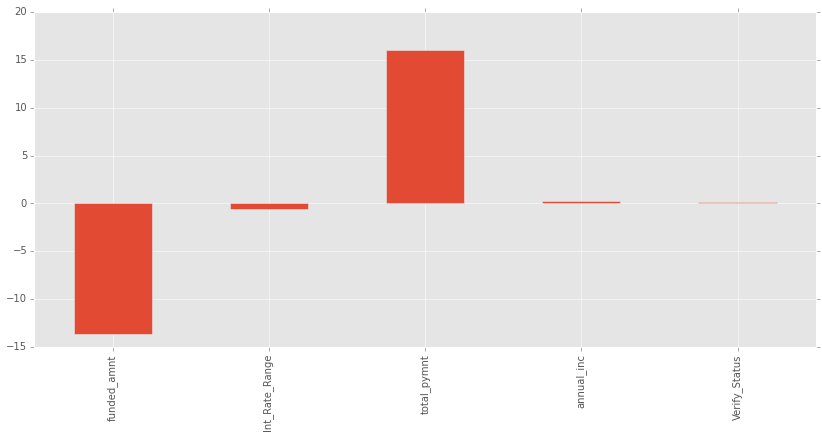

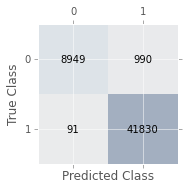

In [19]:
scl = StandardScaler()
scl.fit(updated_X[train_indices])

X_train_scaled = scl.transform(updated_X[train_indices]) # apply to training
X_test_scaled = scl.transform(updated_X[test_indices])

# Fit the regression to the new scaled data
updated_logreg_obj.fit(X_train_scaled, updated_y[train_indices])

y_hat = updated_logreg_obj.predict(X_test_scaled)

# Rescore the accuracy and confusion matrix for the scaled data
acc = mt.accuracy_score(updated_y[test_indices],y_hat)
conf = mt.confusion_matrix(updated_y[test_indices],y_hat)
print 'accuracy:', acc 
print conf
weights = pd.Series(updated_logreg_obj.coef_[0],index=used_temp_df.columns)
weights.plot(kind='bar', figsize=(14,6))

fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(conf, cmap=plt.cm.Blues, alpha = 0.3)
for i in range (conf.shape[0]):
    for j in range (conf.shape[1]):
        ax.text(x=j, y=i, s=conf[i, j], va = 'center', ha = 'center')
plt.xlabel ('Predicted Class')
plt.ylabel ('True Class')
plt.show

## Resubmission Part:
### Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain


Since the SGDClassifier is not the most optimal SVM technique, we will run a full Batch Gradient Descent on the previously created subsampled dataset that has a smaller number of samples for training the model for "finished loans". We will use this subsampled set to find if there are any differences in the findings we have seen so far. Because we have very small sample set, it is important to chose the best parameter set, so we run a "Grid Search" technique to find the best 'C' for the model. We then run the Batch SVM using that model to verify the results for the classifier importance vs Stochastic Gradient Descent we ran previously.

In [20]:
# Split the data into our x and y matrices for testing
if 'isGoodLoan' in subsampled_df:
    updated_subsampled_y = subsampled_df['isGoodLoan'].values
    del subsampled_df['isGoodLoan']
    updated_subsampled_X = subsampled_df.values

# Create a new Shuffle split on the narrowed classification data
num_cv_iterations = 5
num_instances = len(updated_subsampled_y)
updated_cv_obj_subsampled = ShuffleSplit(n = num_instances, n_iter = num_cv_iterations, test_size = 0.2)
print updated_subsampled_X.shape
print updated_subsampled_y.size


(12965L, 51L)
12965


In [21]:
from sklearn.cross_validation import train_test_split

X_train_updated, X_test_updated, y_train_updated, y_test_updated = \
train_test_split(updated_subsampled_X,updated_subsampled_y, test_size = 0.2, random_state = 1)


In [22]:
print X_train_updated.shape
print y_train_updated.shape

(10372L, 51L)
(10372L,)


In [23]:
from sklearn.learning_curve import validation_curve
from sklearn.preprocessing import  StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

pipe_svc = Pipeline([('scl', StandardScaler()), ('clf', SVC(random_state=1))])

param_range = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = [{'clf__C': param_range, 'clf__kernel': ['linear']}]

#Perform grid search to find best C value for SVM
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring = 'accuracy', cv=10, n_jobs=-1)
gs = gs.fit(X_train_updated,y_train_updated)

print (gs.best_score_)
print (gs.best_params_)

0.983898958735
{'clf__C': 100, 'clf__kernel': 'linear'}


Above, we run a grid search in order to find the most efficient 'C' value for the coefficient.

In [24]:
print gs.grid_scores_

[mean: 0.87360, std: 0.00623, params: {'clf__C': 0.001, 'clf__kernel': 'linear'}, mean: 0.95131, std: 0.00656, params: {'clf__C': 0.01, 'clf__kernel': 'linear'}, mean: 0.97532, std: 0.00665, params: {'clf__C': 0.1, 'clf__kernel': 'linear'}, mean: 0.98178, std: 0.00552, params: {'clf__C': 1, 'clf__kernel': 'linear'}, mean: 0.98361, std: 0.00495, params: {'clf__C': 10, 'clf__kernel': 'linear'}, mean: 0.98390, std: 0.00495, params: {'clf__C': 100, 'clf__kernel': 'linear'}]


In [25]:
print (gs.best_params_)
clf = gs.best_estimator_
clf.fit(X_train_updated,y_train_updated)
print ('Test Accuracy for Batch Support vector Machine: ',clf.score(X_test_updated,y_test_updated))

{'clf__C': 100, 'clf__kernel': 'linear'}
('Test Accuracy for Batch Support vector Machine: ', 0.98418819899730048)


The above Grid Search helped us find the most appropriate C value (in this case C is between 10 and 100) for a 'Linear' kernel SVM. We will use the 'C=10' and 'Linear' kernel to check the classifiers importance next.

SVM: 0.987659082144
SVM: 0.975318164288
SVM: 0.987273428461
SVM: 0.984188198997
SVM: 0.981102969533


<function matplotlib.pyplot.show>

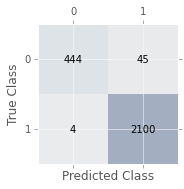

In [26]:
warnings.simplefilter("ignore")
from sklearn.svm import SVC
from sklearn.learning_curve import validation_curve
from sklearn.preprocessing import  StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn import metrics as mt
from matplotlib import pyplot as plt

svm_batch = SVC(kernel = 'linear', C=10)

scl = StandardScaler()


for train_idx, test_idx in updated_cv_obj_subsampled:
    svm_batch.fit(scl.fit_transform(updated_subsampled_X[train_idx]),updated_subsampled_y[train_idx])
    yhat = svm_batch.predict(scl.transform(updated_subsampled_X[test_idx]))
    
    conf = mt.confusion_matrix(updated_subsampled_y[test_idx],yhat)
    acc = mt.accuracy_score(updated_subsampled_y[test_idx],yhat)

    print 'SVM:', acc

fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(conf, cmap=plt.cm.Blues, alpha = 0.3)
for i in range (conf.shape[0]):
    for j in range (conf.shape[1]):
        ax.text(x=j, y=i, s=conf[i, j], va = 'center', ha = 'center')
plt.xlabel ('Predicted Class')
plt.ylabel ('True Class')
plt.show

As we can see, the svm_batch with C=10, and Kernel = 'Linear' is performing well on the test data set. The next step is to check and verify the importance of the classification variables, and make sure there is not a difference from our SGD

Coefficients [[ -6.81506324e+00   7.30007923e-04   2.17502593e-02   4.31078337e-03
    5.07875371e-03  -1.93064085e-02  -2.62295817e-02   4.31210687e-02
    7.88301016e+00   3.76604350e-03  -1.40332480e-02  -1.57781399e-02
    7.19926954e-03   8.69624876e-04   2.18169681e-02   7.12822800e-03
    2.14467048e-02   3.69644560e-03  -3.76182187e-03   1.07032965e-03
    3.28620342e-03   5.47312058e-03  -1.34428433e-02  -2.51982782e-03
   -8.99812036e-03   2.19444238e-02   6.54614085e-03   3.37205792e-03
   -1.25881882e-02  -8.04853612e-02   6.01664524e-03   0.00000000e+00
    5.10477622e-03   0.00000000e+00   5.14727150e-14   1.39936763e-02
   -1.32040084e-02   4.91011647e-03   4.56198737e-03  -4.43435766e-03
    1.88987714e-13  -1.67811856e-03  -3.54723034e-03   1.14826774e-02
    5.15816272e-03   4.31156307e-03   7.43721177e-03  -1.39749323e-14
   -1.33901374e-02  -3.60095996e-03  -2.06705156e-02]]


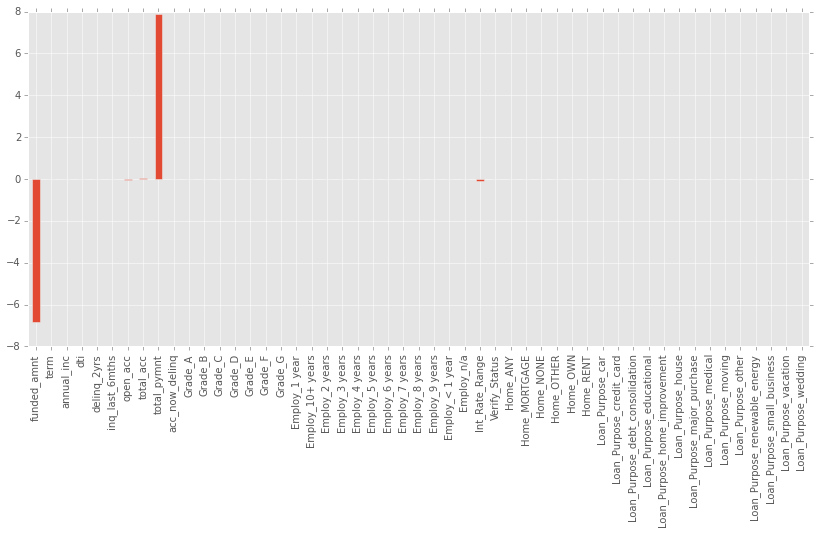

In [27]:
print 'Coefficients', svm_batch.coef_
weights = pd.Series(svm_batch.coef_[0],index=loan_df_finished.columns)
weights.plot(kind='bar', figsize=(14,6))

As can be seen from the above analysis using Batch Gradient Descent, the funded_amnt and total_payment have the highest importance, just as in the Stochastic Gradient Descent. The same features are just as important in both of the models. Both models also had similar accuracy scores with the Batch Gradient Descent model having an accuracy of 98.53% compared to a max accuracy of the SGD (with additional factors taken into account) of 98.8%. The difference between these models is the length of time needed to run them. The Batch gradient takes a much, much longer time to run, even on the subsampled dataset as compared to the SGD. In this case, we would most likely choose the SGD since they both provide similar results, but the SGD runs significantly faster.